In [1]:
import pandas as pd
import seaborn as sns
import sklearn
from tensorflow import keras

In [2]:
%pylab inline 
import seaborn as sns
sns.set()
from IPython.display import SVG

Populating the interactive namespace from numpy and matplotlib


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, InputLayer, Input, Dropout, BatchNormalization

In [6]:
from tensorflow.keras.utils import to_categorical

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LambdaCallback, LearningRateScheduler

In [9]:
from tensorflow.keras.models import load_model, Model

In [25]:
from tensorflow.keras import regularizers

In [10]:
import numpy as np
np.set_printoptions(suppress=True) # Suppress scientific notation where possible

In [11]:
# Make some room to see stuff (i.e. drop display limits on Pandas rows & cols - be careful w/ big df's!)

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', None)

(Class below comes from: https://stackoverflow.com/questions/67271590/issue-with-custom-metric-auc-callback-for-keras)

In [12]:
# Custom skelearn-based AUROC calculation class for use with the FULL validation 
#   set (not just mini-batches) at the end of each training epoch

class ROAUCMetrics(keras.callbacks.Callback):
    def __init__(self, val_data):
        super().__init__()
        self.valid_x = val_data[0]
        self.valid_y = val_data[1]

    def on_train_begin(self, logs={}):
        self.val_aucs = []

    def on_epoch_end(self, epoch, logs={}):
        pred = self.model.predict(self.valid_x)
        val_auc = roc_auc_score(self.valid_y, pred,  average='micro')
        print('\nval-roc-auc: %s' % (str(round(val_auc,4))),end=100*' '+'\n\n')
        self.val_aucs.append(val_auc)
        return

# 1) Import the training data

In [14]:
X_train = np.load('data2/X_baby_train.dat')
y_train = np.load('data2/y_baby_train.dat')

X_val = np.load('data2/X_baby_val.dat')
y_val = np.load('data2/y_baby_val.dat')

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(985, 224, 273, 1)
(985, 4)
(247, 224, 273, 1)
(247, 4)


In [16]:
# Need these to be float32 format for custom loss function to work

y_train = y_train.astype(float)
y_val = y_val.astype(float) 

# 3) Let's Try a Pre-trained Model (VGG16) on just the first target (diagnosis = 'Atelectasis')

In [91]:
## FOR REPEATABILITY (must re-run this before EVERY model training run):

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(0)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(1)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(2)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(2)

In [92]:
# Not sure, but I think this batch_size has to be consistent w/ what is used in the CNN model (which defaults to 32)
batch_size = 32

datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

# calculate mean on training dataset
datagen.fit(X_train)

# prepare iterators to scale images
train_iterator = datagen.flow(X_train, y_train[:, 0], batch_size=batch_size)

val_iterator = datagen.flow(X_val, y_val[:, 0], batch_size=batch_size)

print('Batches train=%d, val=%d' % (len(train_iterator), len(val_iterator)))

Batches train=31, val=8


In [93]:
keras.backend.clear_session()

# dropout = 0.4

from tensorflow.keras.applications import VGG16

# This converts the 1-channel X-rays to 3-channel images a required by mobilenet_v2
input_tensor = Input(shape=(X_train.shape[1:]))
x = Conv2D(3,(3,3),padding='same')(input_tensor)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(X_train.shape[1], X_train.shape[2], 3)) 
 
# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False    

out = base_model(x)
new_base_model = Model(inputs=input_tensor, outputs=out)
    
# Establish new fully connected block
x = new_base_model.output
x = Flatten()(x) # flatten from convolution tensor output 
# x = Dense(units=128, activation='relu')(x) # number of layers and units are hyperparameters, as usual
# x = Dropout(dropout, seed=2)(x) # adding Dropout for regularization between the Dense layers
# x = Dense(units=64, activation='relu')(x)
# x = Dropout(dropout, seed=1)(x) # adding Dropout for regularization between the Dense layers
predictions = Dense(units=1, activation='sigmoid')(x) # 1 target labels

# define formal model object to train and compile it as usual
model = Model(inputs=new_base_model.input, outputs=predictions)

In [94]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 273, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 273, 3)       30        
_________________________________________________________________
vgg16 (Functional)           (None, 7, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 28672)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 28673     
Total params: 14,743,391
Trainable params: 28,703
Non-trainable params: 14,714,688
_________________________________________________________________


In [95]:
initial_learning_rate = 0.0001
adam_opt = keras.optimizers.Adam(learning_rate=initial_learning_rate, 
                                 beta_1=0.9, 
                                 beta_2=0.999, 
                                 epsilon=1e-07, 
                                 amsgrad=False)

model.compile(
    loss='binary_crossentropy',
    optimizer=adam_opt
)

In [96]:
model.optimizer.get_config()['learning_rate']

0.0001

In [97]:
# Exponential decay learning rate scheduler comes from: 
#      https://towardsdatascience.com/learning-rate-schedule-in-practice-an-example-with-keras-and-tensorflow-2-0-2f48b2888a0c
def lr_exp_decay(epoch, lr):
    print('Previous lr: {}'.format(lr))
    k = 0
    return lr * np.exp(-k*epoch)

# This AUC will be calculated at the end of each epoch on the validation set and be used for early stopping
auc = ROAUCMetrics(val_data=(X_val, y_val[:, 0]))

eval_callback = LambdaCallback(on_epoch_end=lambda epoch, logs: logs.update({'auc': auc.val_aucs[-1]})) 

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, mode='min', min_delta=0.0001, min_lr=5e-6)

lr_callback = LambdaCallback(on_epoch_begin=lambda epoch, logs: print('Learning Rate: {}'.format(round(model.optimizer.get_config()['learning_rate'], 7))))

# scheduler = LearningRateScheduler(lr_exp_decay, verbose=1)

early_stopping = EarlyStopping(monitor='auc', mode='max', patience=10, restore_best_weights=True)

history = model.fit(train_iterator, steps_per_epoch=len(train_iterator), epochs=100, verbose=1, validation_data=val_iterator, 
                 callbacks=[
                     auc,
                     eval_callback,
                     reduce_lr,
                     lr_callback,
                     early_stopping,
#                      scheduler,
                     keras.callbacks.ModelCheckpoint(
                         'models_baby/model_3.{epoch:02d}-{val_loss:.2f}.hdf5',
                         save_best_only=True)
                 ])

Epoch 1/100
Learning Rate: 0.0001
31/31 [==============================] - 250s 8s/step - loss: 0.6405 - val_loss: 0.6425

val-roc-auc: 0.5353                                                                                                    

Epoch 2/100
Learning Rate: 9.999999747378752e-05
31/31 [==============================] - 234s 8s/step - loss: 0.5970 - val_loss: 0.6230

val-roc-auc: 0.5777                                                                                                    

Epoch 3/100
Learning Rate: 9.999999747378752e-05
31/31 [==============================] - 230s 7s/step - loss: 0.5726 - val_loss: 0.6189

val-roc-auc: 0.5984                                                                                                    

Epoch 4/100
Learning Rate: 9.999999747378752e-05
31/31 [==============================] - 232s 8s/step - loss: 0.5622 - val_loss: 0.6205

val-roc-auc: 0.6108                                                                                 

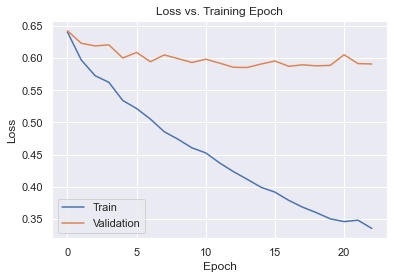

In [98]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Loss vs. Training Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Validation']);

In [99]:
y_pred = model.predict(X_val)

In [100]:
roc_auc_score(y_val[:,0], y_pred)

0.6532797858099063

# 3b) Same as above (1st target only) but with a super simple output from VGG16

In [169]:
## FOR REPEATABILITY (must re-run this before EVERY model training run):

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(0)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(1)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(2)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(2)

In [170]:
batch_size = 256

datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

# calculate mean on training dataset
datagen.fit(X_train)

# prepare iterators to scale images
train_iterator = datagen.flow(X_train, y_train[:, 0], batch_size=batch_size)

val_iterator = datagen.flow(X_val, y_val[:, 0], batch_size=batch_size)

print('Batches train=%d, val=%d' % (len(train_iterator), len(val_iterator)))

Batches train=4, val=1


In [171]:
keras.backend.clear_session()

# dropout = 0.4

from tensorflow.keras.applications import VGG16

# This converts the 1-channel X-rays to 3-channel images a required by mobilenet_v2
input_tensor = Input(shape=(X_train.shape[1:]))
x = Conv2D(3,(3,3),padding='same')(input_tensor)

base_model = VGG16(weights='imagenet', 
                   include_top=False, 
                   pooling='avg',
                   input_shape=(X_train.shape[1], X_train.shape[2], 3)) 
 
# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False    

out = base_model(x)
new_base_model = Model(inputs=input_tensor, outputs=out)
    
# Establish new fully connected block
x = new_base_model.output
x = Flatten()(x) # flatten from convolution tensor output 
# x = Dense(units=128, activation='relu')(x) # number of layers and units are hyperparameters, as usual
# x = Dropout(dropout, seed=2)(x) # adding Dropout for regularization between the Dense layers
# x = Dense(units=64, activation='relu')(x)
# x = Dropout(dropout, seed=1)(x) # adding Dropout for regularization between the Dense layers
predictions = Dense(units=1, activation='sigmoid')(x) # 1 target labels

# define formal model object to train and compile it as usual
model = Model(inputs=new_base_model.input, outputs=predictions)

In [172]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 273, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 273, 3)       30        
_________________________________________________________________
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 14,715,231
Trainable params: 543
Non-trainable params: 14,714,688
_________________________________________________________________


In [173]:
initial_learning_rate = 0.0002828
adam_opt = keras.optimizers.Adam(learning_rate=initial_learning_rate, 
                                 beta_1=0.9, 
                                 beta_2=0.999, 
                                 epsilon=1e-07, 
                                 amsgrad=False)

model.compile(
    loss='binary_crossentropy',
    optimizer=adam_opt
)

In [174]:
model.optimizer.get_config()['learning_rate']

0.0002828

In [ ]:
# Exponential decay learning rate scheduler comes from: 
#      https://towardsdatascience.com/learning-rate-schedule-in-practice-an-example-with-keras-and-tensorflow-2-0-2f48b2888a0c
def lr_exp_decay(epoch, lr):
    print('Previous lr: {}'.format(lr))
    k = 0
    return lr * np.exp(-k*epoch)

# This AUC will be calculated at the end of each epoch on the validation set and be used for early stopping
auc = ROAUCMetrics(val_data=(X_val, y_val[:, 0]))

eval_callback = LambdaCallback(on_epoch_end=lambda epoch, logs: logs.update({'auc': auc.val_aucs[-1]})) 

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, mode='min', min_delta=0.0001, min_lr=5e-6)

lr_callback = LambdaCallback(on_epoch_begin=lambda epoch, logs: print('Learning Rate: {}'.format(round(model.optimizer.get_config()['learning_rate'], 7))))

# scheduler = LearningRateScheduler(lr_exp_decay, verbose=1)

early_stopping = EarlyStopping(monitor='auc', mode='max', patience=10, restore_best_weights=True)

history = model.fit(train_iterator, steps_per_epoch=len(train_iterator), epochs=100, verbose=1, validation_data=val_iterator, 
                 callbacks=[
                     auc,
                     eval_callback,
                     reduce_lr,
                     lr_callback,
                     early_stopping,
#                      scheduler,
                     keras.callbacks.ModelCheckpoint(
                         'models_baby2/model_3b.{epoch:02d}-{val_loss:.2f}.hdf5',
                         save_best_only=False)
                 ])

Epoch 1/100
Learning Rate: 0.0002828


2022-01-18 07:08:05.032270: W tensorflow/core/framework/op_kernel.cc:1755] Invalid argument: ValueError: callback pyfunc_59 is not found
Traceback (most recent call last):

  File "/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 238, in __call__
    raise ValueError("callback %s is not found" % token)

ValueError: callback pyfunc_59 is not found


2022-01-18 07:08:05.032950: W tensorflow/core/kernels/data/generator_dataset_op.cc:107] Error occurred when finalizing GeneratorDataset iterator: Invalid argument: ValueError: callback pyfunc_59 is not found
Traceback (most recent call last):

  File "/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 238, in __call__
    raise ValueError("callback %s is not found" % token)

ValueError: callback pyfunc_59 is not found


	 [[{{node PyFunc}}]]


4/4 [==============================] - 421s 110s/step - loss: 0.8916 - val_loss: 0.8699

val-roc-auc: 0.6037                                                                                                    

Epoch 2/100
Learning Rate: 0.00028279999969527125
4/4 [==============================] - 405s 108s/step - loss: 0.8610 - val_loss: 0.8413

val-roc-auc: 0.6136                                                                                                    

Epoch 3/100
Learning Rate: 0.00028279999969527125
4/4 [==============================] - 421s 107s/step - loss: 0.8342 - val_loss: 0.8146

val-roc-auc: 0.6183                                                                                                    

Epoch 4/100
Learning Rate: 0.00028279999969527125
4/4 [==============================] - 415s 106s/step - loss: 0.8078 - val_loss: 0.7902

val-roc-auc: 0.6214                                                                                                    

Epoch 5/10

In [ ]:
# Best model saved is for epoch 48:  models_baby/model_3b.48-0.59.hdf5

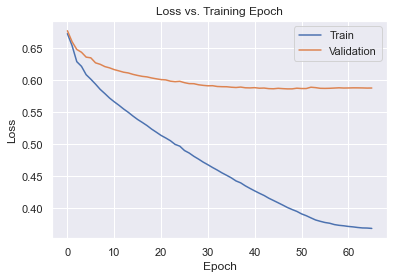

In [155]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Loss vs. Training Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Validation']);

In [156]:
y_pred = model.predict(X_val)

In [157]:
# Initial LR=0.0001, batch_size=256
roc_auc_score(y_val[:,0], y_pred)

0.6513461252417075

In [110]:
# Initial LR=0.0001, batch_size=32
roc_auc_score(y_val[:,0], y_pred)

0.6532797858099063

In [88]:
# Initial LR=0.001, batch_size=32
roc_auc_score(y_val[:,0], y_pred)

0.6481481481481483

# 4) Let's Try InceptionV3 Pre-Trained Model (1st target only)

In [16]:
## FOR REPEATABILITY (must re-run this before EVERY model training run):

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(0)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(1)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(2)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(2)

In [17]:
batch_size = 256

datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

# calculate mean on training dataset
datagen.fit(X_train)

# prepare iterators to scale images
train_iterator = datagen.flow(X_train, y_train[:, 0], batch_size=batch_size)

val_iterator = datagen.flow(X_val, y_val[:, 0], batch_size=batch_size)

print('Batches train=%d, val=%d' % (len(train_iterator), len(val_iterator)))

Batches train=4, val=1


In [18]:
keras.backend.clear_session()

# dropout = 0.4

from tensorflow.keras.applications import InceptionV3

# This converts the 1-channel X-rays to 3-channel images a required by mobilenet_v2
input_tensor = Input(shape=(X_train.shape[1:]))
x = Conv2D(3,(3,3),padding='same')(input_tensor)

base_model = InceptionV3(weights='imagenet',
                         include_top=False,
#                          pooling='avg',
                         input_shape=(X_train.shape[1], X_train.shape[2], 3)) 
 
# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False    

out = base_model(x)
new_base_model = Model(inputs=input_tensor, outputs=out)
    
# Establish new fully connected block
x = new_base_model.output
x = Flatten()(x) # flatten from convolution tensor output 
# x = Dense(units=128, activation='relu')(x) # number of layers and units are hyperparameters, as usual
# x = Dropout(dropout, seed=2)(x) # adding Dropout for regularization between the Dense layers
# x = Dense(units=64, activation='relu')(x)
# x = Dropout(dropout, seed=1)(x) # adding Dropout for regularization between the Dense layers
predictions = Dense(units=1, activation='sigmoid')(x) # 1 target labels

# define formal model object to train and compile it as usual
model = Model(inputs=new_base_model.input, outputs=predictions)

2022-01-18 12:57:54.663855: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 273, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 273, 3)       30        
_________________________________________________________________
inception_v3 (Functional)    (None, 5, 7, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 71680)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 71681     
Total params: 21,874,495
Trainable params: 71,711
Non-trainable params: 21,802,784
_________________________________________________________________


In [20]:
initial_learning_rate = 0.0005
adam_opt = keras.optimizers.Adam(learning_rate=initial_learning_rate, 
                                 beta_1=0.9, 
                                 beta_2=0.999, 
                                 epsilon=1e-07, 
                                 amsgrad=False)

model.compile(
    loss='binary_crossentropy',
    optimizer=adam_opt
)

In [21]:
model.optimizer.get_config()['learning_rate']

0.0005

In [22]:
# Exponential decay learning rate scheduler comes from: 
#      https://towardsdatascience.com/learning-rate-schedule-in-practice-an-example-with-keras-and-tensorflow-2-0-2f48b2888a0c
def lr_exp_decay(epoch, lr):
    print('Previous lr: {}'.format(lr))
    k = 0
    return lr * np.exp(-k*epoch)

# This AUC will be calculated at the end of each epoch on the validation set and be used for early stopping
auc = ROAUCMetrics(val_data=(X_val, y_val[:, 0]))

eval_callback = LambdaCallback(on_epoch_end=lambda epoch, logs: logs.update({'auc': auc.val_aucs[-1]})) 

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, mode='min', min_delta=0.0001, min_lr=5e-6)
reduce_lr = ReduceLROnPlateau(monitor='auc', factor=0.5, patience=2, mode='max', min_delta=0.005, min_lr=1e-6)

lr_callback = LambdaCallback(on_epoch_begin=lambda epoch, logs: print('Learning Rate: {}'.format(round(model.optimizer.get_config()['learning_rate'], 7))))

# scheduler = LearningRateScheduler(lr_exp_decay, verbose=1)

early_stopping = EarlyStopping(monitor='auc', mode='max', patience=10, restore_best_weights=True)

history = model.fit(train_iterator, steps_per_epoch=len(train_iterator), epochs=100, verbose=1, validation_data=val_iterator, 
                 callbacks=[
                     auc,
                     eval_callback,
                     reduce_lr,
                     lr_callback,
                     early_stopping,
#                      scheduler,
                     keras.callbacks.ModelCheckpoint(
                         'models_baby2/model_4.{epoch:02d}-{val_loss:.2f}.hdf5',
                         save_best_only=False)
                 ])

2022-01-18 12:59:05.292119: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
Learning Rate: 0.0005
4/4 [==============================] - 152s 37s/step - loss: 2.4387 - val_loss: 2.9448

val-roc-auc: 0.4309                                                                                                    

Epoch 2/100
Learning Rate: 0.0005000000237487257
4/4 [==============================] - 132s 35s/step - loss: 3.4891 - val_loss: 1.2558

val-roc-auc: 0.4421                                                                                                    

Epoch 3/100
Learning Rate: 0.0005000000237487257
4/4 [==============================] - 134s 34s/step - loss: 1.7520 - val_loss: 0.9891

val-roc-auc: 0.4502                                                                                                    

Epoch 4/100
Learning Rate: 0.0005000000237487257
4/4 [==============================] - 133s 33s/step - loss: 1.5409 - val_loss: 1.1260

val-roc-auc: 0.4446                                                                                     

KeyboardInterrupt: 

# 5) Let's Try ResNet50V2 Pre-Trained Model (1st target only)

In [23]:
## FOR REPEATABILITY (must re-run this before EVERY model training run):

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(0)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(1)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(2)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(2)

In [24]:
batch_size = 256

datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

# calculate mean on training dataset
datagen.fit(X_train)

# prepare iterators to scale images
train_iterator = datagen.flow(X_train, y_train[:, 0], batch_size=batch_size)

val_iterator = datagen.flow(X_val, y_val[:, 0], batch_size=batch_size)

print('Batches train=%d, val=%d' % (len(train_iterator), len(val_iterator)))

Batches train=4, val=1


In [25]:
keras.backend.clear_session()

# dropout = 0.4

from tensorflow.keras.applications import ResNet50V2

# This converts the 1-channel X-rays to 3-channel images a required by mobilenet_v2
input_tensor = Input(shape=(X_train.shape[1:]))
x = Conv2D(3,(3,3),padding='same')(input_tensor)

base_model = ResNet50V2(weights='imagenet',
                         include_top=False,
#                          pooling='avg',
                         input_shape=(X_train.shape[1], X_train.shape[2], 3)) 
 
# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False    

out = base_model(x)
new_base_model = Model(inputs=input_tensor, outputs=out)
    
# Establish new fully connected block
x = new_base_model.output
x = Flatten()(x) # flatten from convolution tensor output 
# x = Dense(units=128, activation='relu')(x) # number of layers and units are hyperparameters, as usual
# x = Dropout(dropout, seed=2)(x) # adding Dropout for regularization between the Dense layers
# x = Dense(units=64, activation='relu')(x)
# x = Dropout(dropout, seed=1)(x) # adding Dropout for regularization between the Dense layers
predictions = Dense(units=1, activation='sigmoid')(x) # 1 target labels

# define formal model object to train and compile it as usual
model = Model(inputs=new_base_model.input, outputs=predictions)

94674944/94668760 [==============================] - 37s 0us/step


In [26]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 273, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 273, 3)       30        
_________________________________________________________________
resnet50v2 (Functional)      (None, 7, 9, 2048)        23564800  
_________________________________________________________________
flatten (Flatten)            (None, 129024)            0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129025    
Total params: 23,693,855
Trainable params: 129,055
Non-trainable params: 23,564,800
_________________________________________________________________


In [27]:
initial_learning_rate = 0.0005
adam_opt = keras.optimizers.Adam(learning_rate=initial_learning_rate, 
                                 beta_1=0.9, 
                                 beta_2=0.999, 
                                 epsilon=1e-07, 
                                 amsgrad=False)

model.compile(
    loss='binary_crossentropy',
    optimizer=adam_opt
)

In [28]:
model.optimizer.get_config()['learning_rate']

0.0005

In [29]:
# Exponential decay learning rate scheduler comes from: 
#      https://towardsdatascience.com/learning-rate-schedule-in-practice-an-example-with-keras-and-tensorflow-2-0-2f48b2888a0c
def lr_exp_decay(epoch, lr):
    print('Previous lr: {}'.format(lr))
    k = 0
    return lr * np.exp(-k*epoch)

# This AUC will be calculated at the end of each epoch on the validation set and be used for early stopping
auc = ROAUCMetrics(val_data=(X_val, y_val[:, 0]))

eval_callback = LambdaCallback(on_epoch_end=lambda epoch, logs: logs.update({'auc': auc.val_aucs[-1]})) 

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, mode='min', min_delta=0.0001, min_lr=5e-6)
reduce_lr = ReduceLROnPlateau(monitor='auc', factor=0.5, patience=2, mode='max', min_delta=0.005, min_lr=1e-6)

lr_callback = LambdaCallback(on_epoch_begin=lambda epoch, logs: print('Learning Rate: {}'.format(round(model.optimizer.get_config()['learning_rate'], 7))))

# scheduler = LearningRateScheduler(lr_exp_decay, verbose=1)

early_stopping = EarlyStopping(monitor='auc', mode='max', patience=10, restore_best_weights=True)

history = model.fit(train_iterator, steps_per_epoch=len(train_iterator), epochs=100, verbose=1, validation_data=val_iterator, 
                 callbacks=[
                     auc,
                     eval_callback,
                     reduce_lr,
                     lr_callback,
                     early_stopping,
#                      scheduler,
                     keras.callbacks.ModelCheckpoint(
                         'models_baby3/model_5.{epoch:02d}-{val_loss:.2f}.hdf5',
                         save_best_only=False)
                 ])

Epoch 1/100
Learning Rate: 0.0005
4/4 [==============================] - 201s 51s/step - loss: 4.2839 - val_loss: 4.9521

val-roc-auc: 0.5                                                                                                    



/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/100
Learning Rate: 0.0005000000237487257
4/4 [==============================] - 189s 50s/step - loss: 4.8136 - val_loss: 2.7152

val-roc-auc: 0.5                                                                                                    



/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 3/100
Learning Rate: 0.0005000000237487257
4/4 [==============================] - 190s 48s/step - loss: 1.9654 - val_loss: 2.7858

val-roc-auc: 0.5001                                                                                                    



/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 4/100
Learning Rate: 0.0002500000118743628
4/4 [==============================] - 194s 49s/step - loss: 1.1887 - val_loss: 1.6872

val-roc-auc: 0.5                                                                                                    



/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 5/100
Learning Rate: 0.0002500000118743628
4/4 [==============================] - 171s 44s/step - loss: 1.2111 - val_loss: 1.9097

val-roc-auc: 0.5                                                                                                    



/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 6/100
Learning Rate: 0.0001250000059371814
4/4 [==============================] - 112s 30s/step - loss: 0.7320 - val_loss: 1.0873

val-roc-auc: 0.5                                                                                                    



/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 7/100
Learning Rate: 0.0001250000059371814
4/4 [==============================] - 208s 53s/step - loss: 0.4443 - val_loss: 1.2605

val-roc-auc: 0.5                                                                                                    



/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 8/100
Learning Rate: 6.25000029685907e-05


KeyboardInterrupt: 

# 6) VGG16 + 3 Dense Layers (128, 64, 1, dropout) w/ trainable layer_5 (last target)

In [79]:
## Targets: 'Atelectasis'=0, 'Cardiomegaly'=1, 'Edema'=2, 'Pleaural Effusion'=3

target = 3

In [80]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
#    The sum of the weights of all examples stays the same.

# weight_for_1 = (1 / pos) * (total / 2.0)
weight_for_1 = (1 / np.sum(y_train[:, target])) * (y_train.shape[0]/2.0)

# weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_0 = (1 / (y_train.shape[0] - np.sum(y_train[:, target]))) * (y_train.shape[0]/2.0)

class_weights = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.77
Weight for class 1: 1.41


In [81]:
## FOR REPEATABILITY (must re-run this before EVERY model training run):

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(0)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(1)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(2)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(2)

In [82]:
batch_size = 256

datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

# calculate mean on training dataset
datagen.fit(X_train)

# prepare iterators to scale images
train_iterator = datagen.flow(X_train, y_train[:, target], batch_size=batch_size)

val_iterator = datagen.flow(X_val, y_val[:, target], batch_size=batch_size)

print('Batches train=%d, val=%d' % (len(train_iterator), len(val_iterator)))

Batches train=4, val=1


In [83]:
keras.backend.clear_session()

from tensorflow.keras.applications import VGG16

# This converts the 1-channel X-rays to 3-channel images a required by mobilenet_v2
input_tensor = Input(shape=(X_train.shape[1:]))
x = Conv2D(3,(3,3),padding='same')(input_tensor)

base_model = VGG16(weights='imagenet', 
                   include_top=False, 
#                    pooling='avg',
                   input_shape=(X_train.shape[1], X_train.shape[2], 3)) 
 
for layer in base_model.layers:
  if 'block5_' not in layer.name:
      layer.trainable = False
      print('Layer ' + layer.name + ' frozen.')
base_model.summary()

Layer input_2 frozen.
Layer block1_conv1 frozen.
Layer block1_conv2 frozen.
Layer block1_pool frozen.
Layer block2_conv1 frozen.
Layer block2_conv2 frozen.
Layer block2_pool frozen.
Layer block3_conv1 frozen.
Layer block3_conv2 frozen.
Layer block3_conv3 frozen.
Layer block3_pool frozen.
Layer block4_conv1 frozen.
Layer block4_conv2 frozen.
Layer block4_conv3 frozen.
Layer block4_pool frozen.
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 273, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 273, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 273, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 136, 64)      0     

In [84]:
dropout = 0.425
l1_reg = 0.00001
l2_reg = 0.0001

out = base_model(x)
new_base_model = Model(inputs=input_tensor, outputs=out)
    
# Establish new fully connected block
x = new_base_model.output
x = Flatten()(x) # flatten from convolution tensor output 
# x = Dense(units=128, activation='relu')(x)
x = Dense(units=128, 
          activation='relu', 
          kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg),
          bias_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg))(x)
x = Dropout(dropout, seed=2)(x) # adding Dropout for regularization between the Dense layers
x = Dense(units=64,
          activation='relu', 
          kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg),
          bias_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg))(x)
x = Dropout(dropout, seed=1)(x) # adding Dropout for regularization between the Dense layers
predictions = Dense(units=1, activation='sigmoid')(x) # 1 target labels

# define formal model object to train and compile it as usual
model = Model(inputs=new_base_model.input, outputs=predictions)

In [85]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 273, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 273, 3)       30        
_________________________________________________________________
vgg16 (Functional)           (None, 7, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 28672)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               3670144   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256

In [86]:
initial_learning_rate = 0.00025
adam_opt = keras.optimizers.Adam(learning_rate=initial_learning_rate, 
                                 beta_1=0.9, 
                                 beta_2=0.999, 
                                 epsilon=1e-07, 
                                 amsgrad=False)

model.compile(
    loss='binary_crossentropy',
    optimizer=adam_opt
)

In [87]:
model.optimizer.get_config()['learning_rate']

0.00025

In [88]:
# Exponential decay learning rate scheduler comes from: 
#      https://towardsdatascience.com/learning-rate-schedule-in-practice-an-example-with-keras-and-tensorflow-2-0-2f48b2888a0c
def lr_exp_decay(epoch, lr):
    print('Previous lr: {}'.format(lr))
    k = 0
    return lr * np.exp(-k*epoch)

# This AUC will be calculated at the end of each epoch on the validation set and be used for early stopping
auc = ROAUCMetrics(val_data=(X_val, y_val[:, target]))

eval_callback = LambdaCallback(on_epoch_end=lambda epoch, logs: logs.update({'auc': auc.val_aucs[-1]})) 

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, mode='min', min_delta=0.0001, min_lr=5e-6)
reduce_lr = ReduceLROnPlateau(monitor='auc', factor=0.5, patience=2, mode='max', min_delta=0.002, min_lr=1e-6)

lr_callback = LambdaCallback(on_epoch_begin=lambda epoch, logs: print('Learning Rate: {}'.format(round(model.optimizer.get_config()['learning_rate'], 7))))

# scheduler = LearningRateScheduler(lr_exp_decay, verbose=1)

early_stopping = EarlyStopping(monitor='auc', mode='max', patience=10, restore_best_weights=True)

history = model.fit(train_iterator, steps_per_epoch=len(train_iterator), epochs=100, verbose=1, validation_data=val_iterator, 
                 callbacks=[
                     auc,
                     eval_callback,
                     reduce_lr,
                     lr_callback,
                     early_stopping,
#                      scheduler,
                     keras.callbacks.ModelCheckpoint(
                         'models_baby3/model_6.{epoch:02d}-{auc:.4f}.hdf5',
                         save_best_only=False)
                 ])

Epoch 1/100
Learning Rate: 0.00025
4/4 [==============================] - 646s 171s/step - loss: 1.0143 - val_loss: 0.9512

val-roc-auc: 0.5467                                                                                                    

Epoch 2/100
Learning Rate: 0.0002500000118743628
4/4 [==============================] - 650s 172s/step - loss: 0.9537 - val_loss: 0.9207

val-roc-auc: 0.6078                                                                                                    

Epoch 3/100
Learning Rate: 0.0002500000118743628
4/4 [==============================] - 629s 159s/step - loss: 0.9172 - val_loss: 0.8739

val-roc-auc: 0.6672                                                                                                    

Epoch 4/100
Learning Rate: 0.0002500000118743628
4/4 [==============================] - 670s 171s/step - loss: 0.8736 - val_loss: 0.8426

val-roc-auc: 0.7146                                                                                

KeyboardInterrupt: 

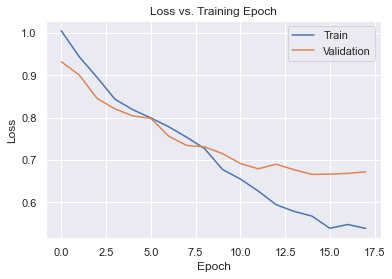

In [49]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Loss vs. Training Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Validation']);

In [89]:
y_pred_val = model.predict(X_val)
y_pred_train = model.predict(X_train)

In [90]:
target

3

In [91]:
# dropout = 0.425
# l1_reg = 0.00001
# l2_reg = 0.0001

print('PRIMARY TARGET ({}):'.format(target))
print('Validation AUC: {}'.format(round(roc_auc_score(y_val[:,target], y_pred_val), 4)))
print('Training AUC: {}'.format(round(roc_auc_score(y_train[:,target], y_pred_train), 4)))

PRIMARY TARGET (3):
Validation AUC: 0.7524
Training AUC: 0.8486


In [78]:
# dropout = 0.4
# l1_reg = 0.000005
# l2_reg = 0.00005

print('PRIMARY TARGET ({}):'.format(target))
print('Validation AUC: {}'.format(round(roc_auc_score(y_val[:,target], y_pred_val), 4)))
print('Training AUC: {}'.format(round(roc_auc_score(y_train[:,target], y_pred_train), 4)))

PRIMARY TARGET (3):
Validation AUC: 0.7553
Training AUC: 0.8675


In [65]:
# dropout = 0.4
# l1_reg = 0.00005
# l2_reg = 0.0005

print('PRIMARY TARGET ({}):'.format(target))
print('Validation AUC: {}'.format(round(roc_auc_score(y_val[:,target], y_pred_val), 4)))
print('Training AUC: {}'.format(round(roc_auc_score(y_train[:,target], y_pred_train), 4)))

PRIMARY TARGET (3):
Validation AUC: 0.7396
Training AUC: 0.8482


# ************ THIS ONE! ************

In [52]:
# dropout = 0.4
# l1_reg = 0.00001
# l2_reg = 0.0001

print('PRIMARY TARGET ({}):'.format(target))
print('Validation AUC: {}'.format(round(roc_auc_score(y_val[:,target], y_pred_val), 4)))
print('Training AUC: {}'.format(round(roc_auc_score(y_train[:,target], y_pred_train), 4)))

PRIMARY TARGET (3):
Validation AUC: 0.7715
Training AUC: 0.8066


In [38]:
# dropout = 0.3
# l1_reg = 0.00001
# l2_reg = 0.0001

print('PRIMARY TARGET ({}):'.format(target))
print('Validation AUC: {}'.format(round(roc_auc_score(y_val[:,target], y_pred_val), 4)))
print('Training AUC: {}'.format(round(roc_auc_score(y_train[:,target], y_pred_train), 4)))

PRIMARY TARGET (3):
Validation AUC: 0.7676
Training AUC: 0.8558
